In [2]:
import numpy as np 
from astropy.io import ascii
from numpy.linalg import norm,eig
import sys
from calc_shape import calc_shape
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits import mplot3d
%matplotlib inline

In [42]:
halo_names = []
host_ids = []
with open('halos_info.txt') as f:
    for l in f:
        this_halo, host_id, block, _ = l.split()
        halo_names.append(this_halo)
        host_ids.append(host_id)


In [4]:
###external haloid == host halo id
###smallest external haloid == subhalo id
###if external haloid == smallest external haloid then particles
# particles belong to smooth component

In [43]:
#for comparing results
def get_angle(v1,v2):
    c = np.dot(v1,v2)/(norm(v1)*norm(v2)) # -> cosine of the angle
    angle = np.arccos(np.clip(c, -1, 1))
    angles = angle*180/np.pi
    return angles

In [142]:
subs = ascii.read('Halo023_sub.particle_table')
hosts = ascii.read('Halo023_host.particle_table')
alls = ascii.read('Halo023_all.particle_table')
hostvalues = ascii.read('/Users/lmezini/proj_2/Halos_Recalculated/Halo023/out_0.list_final',format = 'commented_header')


In [ ]:
host_x = hostvalues['host_x']
host_y = hostvalues['host_y']
host_z = hostvalues['host_z']
rvir = hostvalues['host_rvir'][0]*1e-3 #convert to same units as x,y,z

d = hosts
x = d['x'] - host_x[0]
y = d['y'] - host_y[0]
z = d['z'] - host_z[0]
host_pos = np.array((x,y,z))

d = subs
x = d['x'] - host_x[0]
y = d['y'] - host_y[0]
z = d['z'] - host_z[0]
sub_pos = np.array((x,y,z))

d = alls
x = d['x'] - host_x[0]
y = d['y'] - host_y[0]
z = d['z'] - host_z[0]
all_pos = np.array((x,y,z))
#pos = np.array(list(zip(x, y, z))) #this is used for running yao's code

In [44]:
#calculate starting inertia tensor
def calc_sphere_inertia(p,s=1.,q=1.):
    #p is position vector
    #s,q are axis ratios
    r2 = (p[0]**2 + (p[1]/q)**2 + (p[2]/s)**2)
    Ixx = np.sum((p[0]*p[0])/r2)
    Iyy = np.sum((p[1]*p[1])/r2)
    Izz = np.sum((p[2]*p[2])/r2)
    Ixy = np.sum((p[0]*p[1])/r2)
    Iyz = np.sum((p[1]*p[2])/r2)
    Ixz = np.sum((p[0]*p[2])/r2)
    Iyx = Ixy
    Izy = Iyz
    Izx = Ixz
    I = np.array(((Ixx,Ixy,Ixz),(Iyx,Iyy,Iyz),(Izx,Izy,Izz)))

    return I

def calc_inertia(p,p2,s=1.,q=1.,mass=1.):
    #p is position vector
    #s,q are axis ratios
    r2 = (p2[0]**2 + (p2[1]/q)**2 + (p2[2]/s)**2)
    Ixx = np.sum((p[0]*p[0])/r2)
    Iyy = np.sum((p[1]*p[1])/r2)
    Izz = np.sum((p[2]*p[2])/r2)
    Ixy = np.sum((p[0]*p[1])/r2)
    Iyz = np.sum((p[1]*p[2])/r2)
    Ixz = np.sum((p[0]*p[2])/r2)
    Iyx = Ixy
    Izy = Iyz
    Izx = Ixz
    I = np.array(((Ixx,Ixy,Ixz),(Iyx,Iyy,Iyz),(Izx,Izy,Izz)))/mass

    return I


In [45]:
def get_eigs(I):
    #return eigenvectors and eigenvalues
    w,v = eig(I)
    #sort in descending order
    odr = np.argsort(-1.*w)
    #sqrt of e values = a,b,c
    w_sq = w[odr] 
    w = np.sqrt(w[odr])
    v = v.T[odr]
    #rescale so major axis = radius of original host
    ratio = rvir/w[0]
    w[0] = w[0]*ratio #this one is 'a'
    w[1] = w[1]*ratio #b
    w[2] = w[2]*ratio #c

    return w,v,w_sq

In [46]:
def check_ortho(evect):
    #check if eigen vectors of inertia tensor are orthonormal
    
    #create indentity matrix
    a = np.zeros((3, 3))
    np.fill_diagonal(a, 1.)

    #take dot product of v and v.T
    #off diagonals are usually 1e-15 so round them to 0.
    m = np.abs(np.round(np.dot(evect,evect.T),1))

    #check if all elements are equal to identity matrix
    if np.any(a != m):
        print("not orthonormal")
        sys.exit(1)
    
        

In [47]:
def get_axis(w):
    #return axis ratios
    a,b,c = w
    s = c/a
    q = b/a
    
    return s,q

In [59]:
def transform(p,v):
    #convert to coords of ellipsoid
    #shape is 3 x Number of Particles
    p_new = np.zeros(np.shape(p))
    #loop over each of the 3 coorinates
    for i in range(3):
        p_new[i] += p[0]*v[i,0]+p[1]*v[i,1]+p[2]*v[i,2]
    return p_new


In [60]:
def cut_data(p1,p2,particles,s,q):
    #calculate particle distances in new coord system
    d = p2[0]**2 + (p2[1]/q)**2 + (p2[2]/s)**2
    cut = d<0.00017**2 
    d[cut] = 0.00017**2 #particle distances should not be below force resolution
    #determine which are within the bounds
    cut = d<=(rvir**2)
    p2= p2.T[cut].T #trimmed down in new coord system
    p = p1.T[cut].T #in orig coordinate system
    particles = particles[cut] #

    return p,p2,particles


In [61]:
def get_new_I(p1,p2,s,q,particles=None,halos=None,mass_norm = False):
    #return new inertia tensor using subset of particles within ellipsoid
    #p1,p2 are xyz data in old and new coord system
    #particles contains particle IDs
    
    #calculate new inertia tensor using orig coordinate system
    #r^2 is caluclated in eigen vector coordinate system

    if mass_norm:
        I_tot = np.zeros((3,3))
        #go through all halos in system
        for h in halos:
            #select set of particles belonging to halo
            p_set = particles["smallest_external_haloid"] == h['id']
            p1_temp = p1.T[p_set].T
            p2_temp = p2.T[p_set].T
            h_mass = h['mvir']
            I = calc_inertia(p1_temp,p2_temp,s,q,h_mass)
            I_tot += I
        
        return I_tot

    else:
        I = calc_inertia(p1,p2,s,q)
        
        return I

In [726]:
#this is yao's version
force_res = 0.00017
b_to_a, c_to_a, eig_A = calc_shape(rvir, [0,0,0], pos, force_res)

In [113]:
np.shape(all_pos),np.shape(host_pos),np.shape(sub_pos)

((3, 3281970), (3, 2676526), (3, 705608))

In [119]:
data = all_pos
print('# particles: {}'.format(np.shape(data)[1]))
particles = alls
s,q = 1.,1.
I = calc_sphere_inertia(all_pos,s,q)
err = 1.
tol = .001 #keeping big while testing
it = 0
new_err = 1.
old_err = 10.
while new_err>tol:
    s_old,q_old = s,q
    old_err = new_err
    #get eigen vectors and values of inertia tensor
    w,v,w_sq = get_eigs(I)

    #check if vectors are orthonormal
    check_ortho(v)

    #get new s and q
    s,q = get_axis(w)
    print('s,q: {},{}'.format(s,q))
    #rotate to frame of principle axis 
    data_prime = transform(data,v)

    #select which particles fall within new ellipsoid
    data,data_prime,particles = cut_data(data,data_prime,particles,s,q)
    print('# particles: {}'.format(np.shape(data)[1]))
    #recalculate inertia tensor (can normalize by halo mass)
    I = get_new_I(data,data_prime,s,q,particles,hostvalues,mass_norm = False)

    #compare err to tolerance
    err1 = abs(s_old-s)/s_old
    err2 = abs(q_old-q)/q_old
    new_err = max(err1,err2)

    it += 1
    #if it>9:
    #    break
    """
    plt.scatter(data_prime[1],data_prime[2])
    plt.scatter(0,0)
    plt.axvline(-rvir)
    plt.axvline(rvir)
    #plt.show()
    plt.scatter(data[1],data[2])
    plt.scatter(0,0)
    plt.axvline(-rvir)
    plt.axvline(rvir)
    plt.xlabel('y')
    plt.ylabel('z')
    #plt.show()
    plt.scatter(data[0],data[1])
    plt.scatter(0,0)
    plt.axvline(-rvir)
    plt.axvline(rvir)
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.show()
    plt.scatter(data[1],data[2])
    plt.scatter(0,0)
    plt.axvline(-rvir)
    plt.axvline(rvir)
    plt.xlabel('x')
    plt.ylabel('z')
    #plt.show()
    """
    


# particles: 3281970
s,q: 0.7369301559530483,0.8162447568617168
# particles: 2852222
s,q: 0.6491479989327282,0.7228105851831215
# particles: 2749485
s,q: 0.6094673271023651,0.6757764090474856
# particles: 2685687
s,q: 0.5900636774682413,0.6511398196845744
# particles: 2651342
s,q: 0.580393659226447,0.6373197662221648
# particles: 2632410
s,q: 0.5754990722559404,0.629682213071466
# particles: 2622245
s,q: 0.5729680181712381,0.6254621661288763
# particles: 2616565
s,q: 0.5716558070116874,0.6231181522357887
# particles: 2613446
s,q: 0.5709892713644231,0.6217831587478643
# particles: 2611703
s,q: 0.5706528381682441,0.6210187627722343
# particles: 2610779
s,q: 0.5704801116913669,0.6205910194496593
# particles: 2610218


In [1332]:
host_I = I

In [1245]:
diff_w,diff_v,diff_wv = get_eigs(diff_I)
all_w,all_v,all_wv = get_eigs(all_I)
host_w,host_v,host_wv = get_eigs(host_I)
diff_s,diff_q = get_axis(diff_w)

In [1246]:
diff_s,diff_q

(0.5391436054841496, 0.6794380243383752)

In [1247]:
diff_v[0],all_v[0],host_v[0]

(array([0.95541073, 0.09903495, 0.27817695]),
 array([0.95540383, 0.09905682, 0.27819286]),
 array([-0.89085571, -0.26379487, -0.36984911]))

In [1250]:
get_angle(host_v[0],diff_v[0])

168.56247645342185

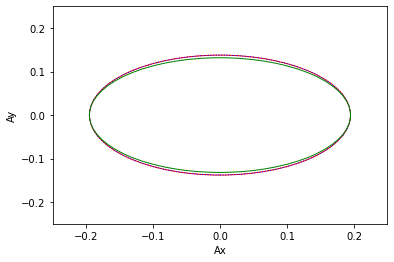

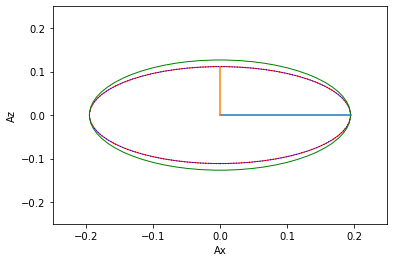

In [1213]:
plt.figure()
ax = plt.gca()

ellipse_diff = Ellipse(xy=(0,0), width=2*diff_w[0], height=2*diff_w[1], 
                        edgecolor='r', fc='None', lw=1)
ellipse_all = Ellipse(xy=(0,0), width=2*all_w[0], height=2*all_w[1], 
                        edgecolor='b', fc='None', lw=1,linestyle=':')
ellipse_host = Ellipse(xy=(0,0), width=2*host_w[0], height=2*host_w[1], 
                        edgecolor='g', fc='None', lw=1)
ax.add_patch(ellipse_diff)
ax.add_patch(ellipse_all)
ax.add_patch(ellipse_host)
plt.xlim(-.25,.25)
plt.ylim(-.25,.25)
plt.xlabel('Ax')
plt.ylabel('Ay')
plt.show()

plt.figure()
ax = plt.gca()

ellipse_diff = Ellipse(xy=(0,0), width=2*diff_w[0], height=2*diff_w[2], 
                        edgecolor='r', fc='None', lw=1)
ellipse_all = Ellipse(xy=(0,0), width=2*all_w[0], height=2*all_w[2], 
                        edgecolor='b', fc='None', lw=1,linestyle=':')
ellipse_host = Ellipse(xy=(0,0), width=2*host_w[0], height=2*host_w[2], 
                        edgecolor='g', fc='None', lw=1)
ax.add_patch(ellipse_diff)
ax.add_patch(ellipse_all)
ax.add_patch(ellipse_host)
plt.xlim(-.25,.25)
plt.ylim(-.25,.25)
plt.plot([0,diff_w[0]],[0,0])
plt.plot([0,0],[0,diff_w[2]])
plt.xlabel('Ax')
plt.ylabel('Az')
plt.show()

In [105]:
I_all = np.load('mwm_all_inertia_tensor_no_norm.npy')
I_host = np.load('mwm_host_inertia_tensor_no_norm.npy')
#I_host = np.load('mwm_host_inertia_tensor_1it.npy')
#I_host = np.load('mwm_host_inertia_tensor_no_norm_1it.npy')
#I_host = np.load('mwm_host_inertia_tensor.npy')
I_subs = I_all - I_host

In [106]:
I_host

array([[[ 9.35096437e-07,  1.13962907e-07,  1.60710305e-07],
        [ 1.13962907e-07,  5.69964818e-07,  5.51044952e-08],
        [ 1.60710305e-07,  5.51044952e-08,  5.94930751e-07]],

       [[ 4.42289171e-07, -1.54592361e-07, -8.32774679e-08],
        [-1.54592361e-07,  3.97659932e-07,  3.98126744e-08],
        [-8.32774679e-08,  3.98126744e-08,  3.23119438e-07]],

       [[ 6.09358366e-07, -4.75984530e-08,  1.00903968e-07],
        [-4.75984530e-08,  7.06436551e-07,  2.14594815e-07],
        [ 1.00903968e-07,  2.14594815e-07,  4.61144625e-07]],

       [[ 6.45310834e-07, -2.16864964e-07,  1.90122533e-08],
        [-2.16864964e-07,  8.90480098e-07, -1.45635379e-07],
        [ 1.90122533e-08, -1.45635379e-07,  6.19052502e-07]],

       [[ 9.27379683e-07, -3.82179459e-07,  2.15110265e-08],
        [-3.82179459e-07,  6.07983235e-07,  7.58640897e-09],
        [ 2.15110265e-08,  7.58640897e-09,  4.64071479e-07]],

       [[ 7.48752326e-07, -1.68187477e-08,  1.97378153e-07],
        [-1.68

In [97]:
for i in range(1):
    w,v,wv = get_eigs(I_subs[i])
    host_w,host_v,host_wv = get_eigs(I_host[i])

In [98]:
new_v = transform(v.T,host_v)

In [99]:
r = np.sqrt(new_v[0][0]**2+new_v[0][1]**2)/norm(np.sqrt(new_v[0][0]**2+new_v[0][1]**2))
theta = np.arctan(new_v[0][1]/new_v[0][0])

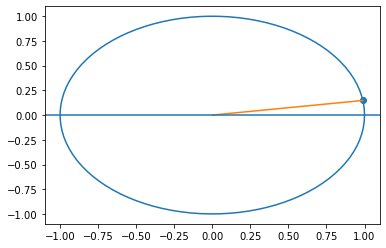

In [100]:
ang = np.linspace(0,2*np.pi,100)
plt.plot(np.cos(ang),np.sin(ang))
plt.scatter(r*np.cos(theta),r*np.sin(theta))
plt.plot([0,r*np.cos(theta)],[0,r*np.sin(theta)])
plt.axhline(0)

In [123]:
arr = np.array((1,2,3,4,5,6,7,8))
arr[-2:]

array([7, 8])